# Alternative Approaches to Perceptron

In [ ]:
# Distribution of data
# Batch training
# 

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import scipy.io as spio
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import math
import urllib
from urllib.request import urlopen
%matplotlib inline
import urllib.request
import datetime as dt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
link = "http://www0.cs.ucl.ac.uk/staff/M.Herbster/SL/misc/zipcombo.dat"
filename = 'zipcombo.dat'
urllib.request.urlretrieve(link, filename)
data = np.loadtxt(filename)     # read numpy array from fil

In [4]:
y = data[:,0]
x = data[:,1:]

# Q6 - Alternative generalization method, One vs. One

In [151]:
def allocate_training_test_sets(data,r =1/5, random_split=False):
    if random_split:
        np.random.shuffle(data)
    X= data[:,1:]
    y= data[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r)
    return X_train, X_test, y_train, y_test

def add_bias(x):
    x_with_bias = np.ones((x.shape[0],x.shape[1]+1))
    x_with_bias[:,:-1] = x
    return x_with_bias


def calculate_kernel_double(x1, x2, d, kernel_choice):
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x1,x2,d)
#         print("Constructed a Polynomial kernel for testing")
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_double(x1, x2)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
#         print("Constructed a Gaussian kernel for testing")
    else:
        raise Exception("Unsupported value for kernel. Supported values: Polynomial, Gaussian")
    return K_train



def calculate_kernel_single(x, d, kernel_choice):
    if kernel_choice=='Polynomial':
        K_train = Polynomial_Kernel(x,x,d)
#         print("Constructed a Polynomial kernel for training")
    elif kernel_choice=='Gaussian':
        pairwise_distances = pairwise_distance_single(x)
        K_train = Gaussian_Kernel(pairwise_distances,c=d)
#         print("Constructed a Gaussian kernel for training")
    else:
        raise Exception("Unsupported value for kernel. Supported values: Polynomial, Gaussian")
    return K_train


#Discuss the use of the this kernel. i.e. talk about non-linear seperability. 
def Polynomial_Kernel(x1,x2,d):
    K = (x1 @ x2.T)**d
    return K

def pairwise_distance_single(X): # distances of X training data, single X matrix
    m =X.shape[0]
    n = X.shape[1]
    G = np.matmul(X,X.T)
    DG = np.diag(G).reshape(G.shape[0],1)
    distances_sq = np.matmul(DG,np.ones((G.shape[0],1)).T)+ np.matmul(np.ones((G.shape[1],1)),DG.T)-2.0*G
    return distances_sq

def pairwise_distance_double(X1,X2): # distances of X training data, double matrices, X1 and X2
    X1_pow = (X1**2).sum(axis=1).reshape(X1.shape[0],1) #sum the rows, size m1 array
    X2_pow = (X2**2).sum(axis=1).reshape(X2.shape[0],1) #sum the rows, size m2 array
    G = np.matmul(X1,X2.T)
    m1,m2 =G.shape[0],G.shape[1] 
    distances_sq = np.matmul(X1_pow,np.ones((m2,1)).T)+ np.matmul(np.ones((m1,1)),X2_pow.T)-2.0*G
    return distances_sq

def Gaussian_Kernel(distances_sq,c=1):
    K = np.exp(-c*distances_sq)
    return K

## One vs. One Pairwise Multiclass Perceptron

In [262]:
#One vs. one approach: train k*(k-1)/2 binary classifiers to identify k classes
#For example, one classifier could be trained to distinguish between digit 0 and digit 1.
#Consider symmetry when computing prediction

#Write a function that trains a binary classifier given two classes, given kernel:
def classifier_ovo(class1,class2,K,alpha_ovo,iter_num):
    vote = np.sign(((alpha_ovo[:].T @K[iter_num,:]).T))
    return vote #returns a vote, within (-1,1)

def perceptron_train_ovo(x,y,d=2,kernel_choice='Polynomial',max_epoch=10, tol=0.01):
    m = x.shape[0] #number of examples
    n = x.shape[1] #number of features
    classes_num = 10 #number of classes 
    error_per_epoch = np.zeros(max_epoch)
    errors = np.zeros(m)
    
    K_train = calculate_kernel_single(x, d, kernel_choice)
    
    num_errors = 0 
    alpha = np.zeros((m,classes_num,classes_num)) 
    
    for epoch in range(max_epoch):
        errors = np.zeros(m)
        num_errors = 0 #This should be bounded..? Maybe calculate the bound in the explanation
    
        #iterate through training set
        for t in range(m):
            if t<1:
                alpha_prev = alpha[0,:,:] #when t=0, the previous alpha is set to be 0
            else:
                alpha_prev = alpha[t-1,:,:] #

            x_t = x[t,:]
            y_t = y[t]

            votes_board = np.zeros((classes_num, classes_num)) #zero on the horizontal. 
            classes_list = np.array(range(classes_num))


            for i in range(classes_num):
                c1 = classes_list[i]
                classes_rest = classes_list[classes_list>c1]
                for j in range(len(classes_rest)):
                    c2 = classes_rest[j]
                    alpha_ovo = alpha[:,c1,c2]
                    vote = classifier_ovo(c1,c2,K_train,alpha_ovo,iter_num=t)
                    votes_board[c1,c2] = vote

            #Count the votes in the board
            votes_count = votes_board.sum(axis=0)
            pred_t = votes_count.argmax()

            if pred_t!=y_t:
                num_errors +=1

                #increase alpha for all the positive classifier of the correct label.
                #decrease alpha for the negative classifier of the false label. 
                alpha_t = alpha_prev #initialize it to its previous form
                alpha_t[:,int(y_t)] =+1 # column belonging to correct label class +=1
                alpha_t[:,int(pred_t)] =-1 # column belonging to false predicted class -=1

                #store alpha_t into the matrix for future reference
                alpha[t,:,:] = alpha_t
            
            errors[t] = num_errors 
        
        error_per_epoch[epoch] = errors[-1]
        #print(epoch, 'error=',errors[-1])
        
        if epoch>1:
            diff_rates = (error_per_epoch[epoch-1] - error_per_epoch[epoch])/m
            
            #Stop if the error rate has increased, 
            #or the difference in error rate between the previous one and the current one < tolerance. 
            if diff_rates<tol or diff_rates<0:
                print('difference in error rate', diff_rates)
                print('break point at epoch=', epoch )
                break
        
    return alpha, error_per_epoch[:epoch+1]



def perceptron_test_ovo(x_test,x_train,y_test,alphas, d,kernel_choice='Polynomial'):
    m_test = x_test.shape[0]
    m_train = x_train.shape[0]
    
    K_test = calculate_kernel_double(x_train, x_test, d, kernel_choice)
    
    classes_num = 10
    classes_list = np.array(range(classes_num))
    votes_ovo =np.zeros((m_test,10,10))
    
    for i in range(classes_num):
        c1 = classes_list[i]
        classes_rest = classes_list[classes_list>c1]
        for j in range(len(classes_rest)):
            c2 = classes_rest[j]
            alphas_ovo_c1c2 = alphas[:,int(c1),int(c2)]
            vote = np.sign(alphas_ovo_c1c2.T@K_test) 
            votes_ovo[:,c1,c2] = vote
                
    sum_votes = np.sum(votes_ovo,axis=1)
    pred = sum_votes.argmax(axis=1)
    diff = pred - y_test
    mistakes = len(diff[diff!=0])
    
    return mistakes,pred

In [206]:
def construct_dataframe_error_rates(training_set_errors, test_set_errors):
    means_std = []
    for d in d_arr:
        data_t = []
        data_t.append("{0:.4f} +- {1:.4f}".format(training_set_errors[d-1].mean(), \
                                                np.std(training_set_errors[d-1])))
        data_t.append("{0:.4f} +- {1:.4f}".format(test_set_errors[d-1].mean(), \
                                                np.std(test_set_errors[d-1])))
        means_std.append(data_t)
    return means_std
    

In [211]:
def basic_results(d_arr, kernel_choice, runs):
    training_set_errors = np.zeros((len(d_arr),runs))
    test_set_errors = np.zeros((len(d_arr),runs))
    for d in d_arr:
        for i in range(runs):
            print("Now doing run ", i+1, "/", runs, " for d=", d,".........", end='\r')
            X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
            
            alphas,train_errors = perceptron_train_ovo(X_train,y_train, d)
            predictions, test_error = perceptron_test_ovo(X_test,X_train, y_test, alphas,d)

            #train_errors,_,_ = perceptron_test(X_train, X_train, y_train, alphas,d, kernel_choice=kernel_choice)
            #test_errors,_,_ = perceptron_test(X_test,X_train, y_test,alphas,d, kernel_choice=kernel_choice)

            training_set_errors[d-1, i] = train_errors / len(y_train)
            test_set_errors[d-1, i] = test_errors / len(y_test)
    return training_set_errors, test_set_errors
            

### Experiment on all training data and test data, d=2

In [202]:
startTime = datetime.now()
X_train, X_test, y_train, y_test = allocate_training_test_sets(data,r =1/5)
alphas_ovo, train_errors = perceptron_train_ovo(X_train,y_train, d=2,max_epoch=10)
test_errors,predictions = perceptron_test_ovo(X_test, X_train, y_test, alphas_ovo, 2)
print(datetime.now() - startTime )

difference in error rate 0.009545576767948373
break point at epoch= 3
0:01:13.539959


In [203]:
train_errors

array([1411.,  700.,  578.,  507.])

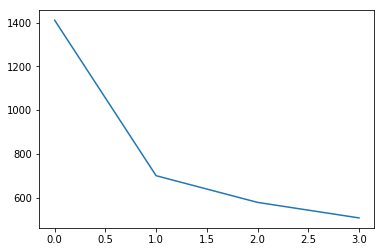

In [204]:
plt.plot(train_errors)

### Basic Results  - Polynomial Kernel

In [68]:
d_arr = np.arange(1,8)
runs = 20
training_set_errors = np.zeros((len(d_arr),runs))
test_set_errors = np.zeros((len(d_arr),runs))

for d in d_arr:
    for i in range(runs):
        startTime = datetime.now()
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)
        alphas,train_errors = perceptron_train_ovo(X_train,y_train, d)
        predictions, test_error = perceptron_test_ovo(X_test,X_train, y_test, alphas,d)
        
        training_set_errors[d-1, i] = train_errors[-1]
        test_set_errors[d-1, i] = test_error
        print("Now doing run ", i, "/", runs, " for d=", d,".........", end='\r')
        print("Time taken: ", datetime.now() - startTime )
    

Time taken:  0:02:06.850727d= 1 .........
Time taken:  0:01:34.001226d= 1 .........
Time taken:  0:01:30.258883d= 1 .........
Time taken:  0:01:31.067757d= 1 .........
Time taken:  0:01:45.497868d= 1 .........
Time taken:  0:01:29.221478d= 1 .........
Time taken:  0:01:29.647567d= 1 .........
Time taken:  0:37:47.489077d= 1 .........
Time taken:  0:02:08.405380d= 1 .........
Time taken:  0:02:11.632202d= 1 .........
Time taken:  0:02:20.107663 d= 1 .........
Time taken:  0:01:36.432795 d= 1 .........
Time taken:  0:01:31.106984 d= 1 .........
Time taken:  0:01:41.431903 d= 1 .........
Time taken:  0:02:05.996656 d= 1 .........
Time taken:  0:01:37.294993 d= 1 .........
Time taken:  0:01:47.028888 d= 1 .........
Time taken:  0:02:17.003802 d= 1 .........
Time taken:  0:02:00.293113 d= 1 .........
Time taken:  0:01:43.101110 d= 1 .........
Time taken:  0:01:50.043767d= 2 .........
Time taken:  0:02:00.766049d= 2 .........
Time taken:  0:01:31.958548d= 2 .........
Time taken:  0:01:48.359

In [131]:
pd.DataFrame(test_set_errors)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,244.0,253.0,273.0,277.0,249.0,246.0,247.0,244.0,229.0,265.0,245.0,283.0,261.0,270.0,246.0,263.0,245.0,260.0,230.0,279.0
1,144.0,146.0,160.0,158.0,153.0,171.0,160.0,162.0,143.0,162.0,150.0,152.0,127.0,150.0,183.0,151.0,156.0,152.0,173.0,169.0
2,119.0,135.0,101.0,127.0,114.0,132.0,135.0,103.0,119.0,126.0,128.0,109.0,110.0,139.0,117.0,117.0,106.0,135.0,110.0,117.0
3,103.0,93.0,101.0,108.0,102.0,106.0,112.0,117.0,98.0,103.0,105.0,100.0,95.0,86.0,107.0,107.0,88.0,108.0,104.0,100.0
4,83.0,108.0,85.0,93.0,120.0,85.0,85.0,102.0,92.0,103.0,91.0,97.0,100.0,94.0,91.0,82.0,128.0,79.0,98.0,103.0
5,70.0,87.0,103.0,84.0,85.0,80.0,82.0,99.0,99.0,95.0,84.0,103.0,92.0,82.0,92.0,93.0,97.0,103.0,86.0,92.0
6,90.0,77.0,78.0,96.0,98.0,99.0,96.0,110.0,94.0,78.0,97.0,96.0,83.0,92.0,90.0,99.0,95.0,75.0,90.0,82.0


In [133]:
pd.DataFrame(test_set_errors).to_pickle('test_errors_basic_ovo') 

In [134]:
pd.DataFrame(training_set_errors).to_pickle('train_errors_basic_ovo') 

In [140]:
means_std = []
for d in d_arr:
    data_t = []
    data_t.append("{0:.4f} +- {1:.4f}".format(training_set_errors[d-1].mean() / len(y_train), \
                                            np.std(training_set_errors[d-1]) / len(y_train)))
    data_t.append("{0:.4f} +- {1:.4f}".format(test_set_errors[d-1].mean() / len(y_test), \
                                            np.std(test_set_errors[d-1]) / len(y_test)))
    means_std.append(data_t)
    
df = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
df

,Training set error rate,Test set error rate
1,0.1327 +- 0.0041,0.1373 +- 0.0082
2,0.0637 +- 0.0032,0.0839 +- 0.0065
3,0.0366 +- 0.0031,0.0645 +- 0.0061
4,0.0228 +- 0.0018,0.0549 +- 0.0040
5,0.0176 +- 0.0019,0.0516 +- 0.0066
6,0.0125 +- 0.0015,0.0486 +- 0.0047
7,0.0104 +- 0.0018,0.0488 +- 0.0048


In [216]:
#means_std = construct_dataframe_error_rates(training_set_errors, test_set_errors)
#df2 = pd.DataFrame(data=means_std, index=d_arr, columns=['Training set error rate', 'Test set error rate'])
#df2

In [142]:
pd.DataFrame(df).to_pickle('basic_ovo') 

### Cross Validation - Polynomial Kernel

In [ ]:
#Cross Validation of One vs. One
def cross_validation_ovo(matrix,d,k=5,kernel_choice='Polynomial'):
    #np.random.shuffle(matrix)
    kf = KFold(n_splits=k)
    error_cv_arr = np.zeros(k)
    i=0
    
    for train_index, cv_index in kf.split(matrix):
        # Spit the matrix using the indices gained by the CV method and construct X and Y arrays
        matrix_train, matrix_cv = matrix[train_index], matrix[cv_index]

        X_train = matrix_train[:,0:-1]
        X_cv = matrix_cv[:,0:-1]
        y_train = matrix_train[:,-1] 
        y_cv = matrix_cv[:,-1]

        # We are only interested in the alphas and not the MSE on the training set
        alphas, train_errors = perceptron_train_ovo(X_train,y_train, d, kernel_choice)
        cv_errors,predictions = perceptron_test_ovo(X_cv, X_train, y_cv, alphas, d, kernel_choice)
        error_cv_arr[i] = cv_errors
        i += 1
        
        return error_cv_arr.mean(), (error_cv_arr.var())**(1/2)

In [268]:
def cv_process_ovo(data, d_arr, runs, kernel_choice, calculate_confusions):
    d_stars = np.zeros(runs)
    test_errors = np.zeros(runs)
    confusions = []
    mistakes_per_run = np.zeros(x.shape[0])

    for j in range(runs):
        np.random.shuffle(data)
        confusion = np.zeros((10, 10))

        print("WARNING: Change the number of runs to 20!!!")
        # In each run we will iterate through the d array and use all possible values of d

        # Allocate 80/20 percent for training and test set
        X_train, X_test, y_train, y_test = allocate_training_test_sets(data, r=1/5)

        CV_means = np.zeros(len(d_arr))
        
        for i in range(len(d_arr)):
            print("d=", d_arr[i])
            print("Now doing run ", j+1, "/", runs, " for d=", d_arr[i], ".........", end='\r')
            errors_CV_mean, _ = cross_validation_ovo(data,d_arr[i],k=5,kernel_choice='Polynomial')
            print("CV mean error=", errors_CV_mean )
            CV_means[i] = errors_CV_mean
            print('CV mean errors=', errors_CV_mean)
            

        # Train in whole 80% now with d_star
        d_stars[j] = d_arr[CV_means.argmin()]
        print('d_stars',d_stars[j])
        alphas, errors = perceptron_train_ovo(X_train, y_train, d_stars[j], kernel_choice = kernel_choice)

        mistakes,_ = perceptron_test_ovo(X_test, X_train, y_test, alphas, d_stars[j], kernel_choice = kernel_choice)
        test_errors[j] = mistakes / len(y_test)
        
        if calculate_confusions:
            # Test in all the data set, so that we know which ones
            # are the "toughest" to predict in the whole data set. We can't really just do it on 
            # either the training or test set, as it is randomly split so order will not be pertained.
            _, preds_all, confidences = perceptron_test_ovo(x, X_train, y, alphas, d_stars[j], kernel_choice = kernel_choice)
            for i in range(x.shape[0]):
                pred_label = preds_all[i].argmax()
                if pred_label != y[i]:
                    confusion[int(y[i]), pred_label] += 1
                    mistakes_per_run[i] += 1

            confusions.append(confusion)
    return d_stars, test_errors, confusions, mistakes_per_run

In [271]:
#There are some problems to be fixed in cross validation function: same error for all values of d?
runs = 2
d_arr = np.arange(1,8)
d_stars, test_errors, confusions, mistakes_per_run = cv_process_ovo(data, d_arr, runs, 'Polynomial', False)